### Importar librerías y datos

In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import warnings

In [232]:
peheader = pd.read_csv("PE_Header.csv")
pesection = pd.read_csv("PE_Section.csv")
dllimported = pd.read_csv("DLLs_Imported.csv")
# apifunctions = pd.read_csv("API_Functions.csv") 1,20 GB (1.296.010.717 bytes), por lo que no lo vamos a abrir ni procesar

##### DLLs_Imported.csv
Qué DLLs importó (presencia binaria o conteo), y su familia (Type)

##### PE_Header.csv
Características del encabezado del archivo ejecutable (como tamaño, timestamp, versión, etc.)

##### PE_Section.csv
Información detallada sobre las secciones del ejecutable (como .text, .data, .rdata, etc.)

##### API_Functions.csv
Similar al de DLLs, pero centrado en funciones API específicas llamadas por el malware. Ha sido descartado porque contiene demasiadas filas y requiere de un coste computacional elevado cargar todas las filas y trabajar con esas dimensiones.

### Reducción del dataset

In [235]:
print("El tamaño de PE_Header es: ", peheader.shape)
print("El tamaño de PE_Section es: ", pesection.shape)
print("El tamaño de DLLs_Imported es: ", dllimported.shape)
# print("El tamaño de API_Functions es: ", apifunctions.shape)

El tamaño de PE_Header es:  (29807, 54)
El tamaño de PE_Section es:  (29760, 92)
El tamaño de DLLs_Imported es:  (29498, 631)


In [236]:
# combinando los tres datasets sin el preprocesado para medir el impacto en la predicción
merged_unprocessed_df = dllimported.merge(peheader, on='SHA256', how='inner', suffixes=('', '_header')) # para indicar que esas columnas pertenecen al dataset de header
merged_unprocessed_df = merged_df.merge(pesection, on='SHA256', how='inner', suffixes=('', '_section')) # para indicar que las columnas pertenecen al dataset de section

In [263]:
merged_unprocessed_df.shape

(29495, 178)

In [237]:
#print(peheader.columns)
#print(pesection.columns)
#print(dllimported.columns)

#### Revisión de nulos (NaN)

In [239]:
print("NaNs en DLLs_Imported:")
nan_dll = dllimported.isna().sum()
nan_dll = nan_dll[nan_dll > 0]
if not nan_dll.empty:
    print(nan_dll)
else:
    print("No hay valores nulos.")

print("\nNaNs en PE_Header:")
nan_header = peheader.isna().sum()
nan_header = nan_header[nan_header > 0]
if not nan_header.empty:
    print(nan_header)
else:
    print("No hay valores nulos.")

print("\nNaNs en PE_Section:")
nan_section = pesection.isna().sum()
nan_section = nan_section[nan_section > 0]
if not nan_section.empty:
    print(nan_section)
else:
    print("No hay valores nulos.\n")


NaNs en DLLs_Imported:
No hay valores nulos.

NaNs en PE_Header:
No hay valores nulos.

NaNs en PE_Section:
No hay valores nulos.



#### Descarte variables con poca diversidad

In [241]:
def plot_column_variability(df, exclude_cols=['SHA256', 'Type'], top_n=50, title='Variabilidad columnas'):
    # Para cada columna, calcula la frecuencia relativa del valor más común
    col_variability = {}
    for col in df.columns:
        if col not in exclude_cols:
            frec = df[col].value_counts(normalize=True, dropna=False).max()
            col_variability[col] = frec

    # Ordena de mayor a menor (más constante a menos constante)
    sorted_vars = dict(sorted(col_variability.items(), key=lambda item: item[1], reverse=True))

    # Seleccionar top N columnas con menor variabilidad (mayor valor dominante)
    top_cols = list(sorted_vars.keys())[:top_n]
    top_vals = [sorted_vars[col] for col in top_cols]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_cols, y=top_vals, palette='crest')
    plt.xticks(rotation=90)
    plt.ylabel('Frecuencia valor dominante')
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

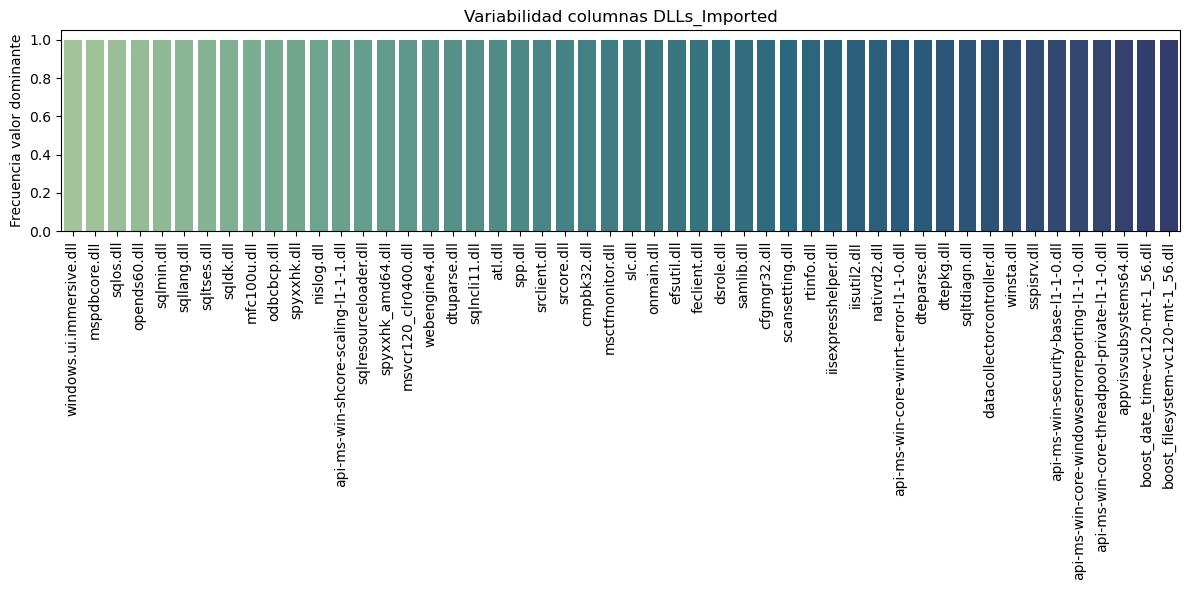

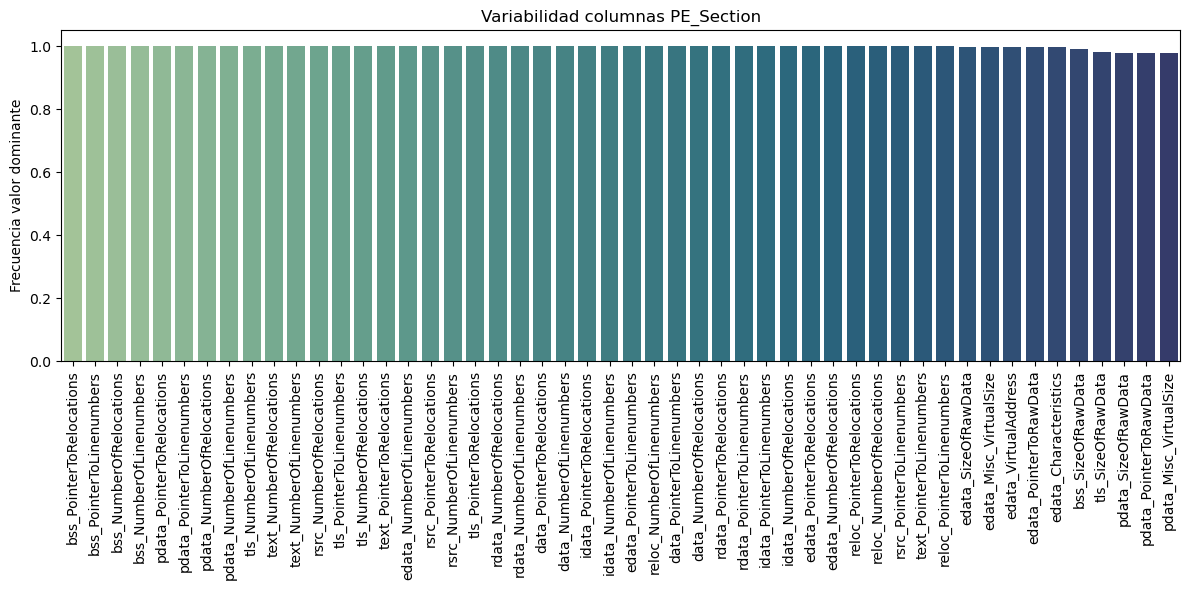

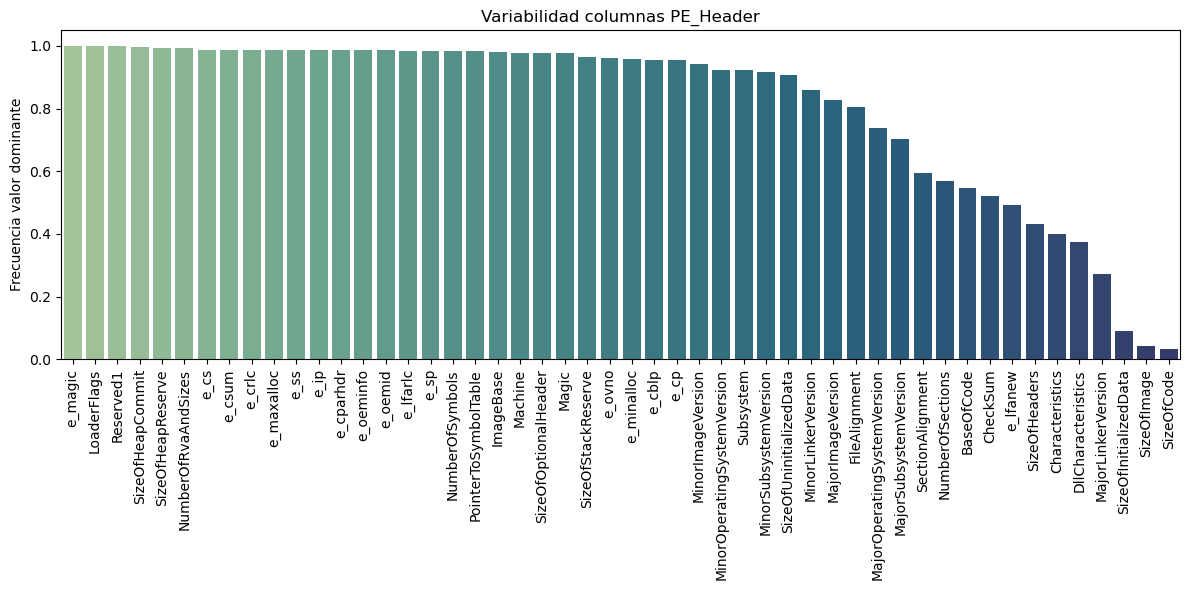

In [242]:
warnings.filterwarnings("ignore", category=FutureWarning)
plot_column_variability(dllimported, title='Variabilidad columnas DLLs_Imported')
plot_column_variability(pesection, title='Variabilidad columnas PE_Section')
plot_column_variability(peheader, title='Variabilidad columnas PE_Header')

Para analizar la calidad y utilidad de las variables presentes en los tres datasets (DLLs_Imported, PE_Section, y PE_Header), se estudió la frecuencia relativa del valor más común en cada columna, permitiendo identificar variables con baja variabilidad, dicho de otra forma, aquellas que contienen prácticamente el mismo valor en casi todas las observaciones.

El gráfico de barras muestra estas columnas ordenadas de mayor a menor concentración del valor dominante (de izquierda a derecha). Una barra más alta y posicionada a la izquierda indica que la columna tiene poca o nula variabilidad, lo cual sugiere bajo poder informativo para futuras labores de clasificación.

- En el caso de DLLs_Imported y PE_Section, encontramos una alta cantidad de columnas que no aportan variabilidad al dataset. Estas variables se acercan al 100% de valores idénticos en todos los procesos, poniéndose en cabeza variables como "windows.ui.immersive.dll" y "bss_PointerToRelocations", respectivamente.
- En el caso del dataset PE_Header muestra un conjunto más reducido de columnas con baja variabilidad. Esto sugiere que los metadatos contenidos en el encabezado PE aportan una mayor diversidad de información estructural, potencialmente útil para tareas de clasificación.

Tras un primer análisis exploratorio, se observa que hay una gran cantidad de variables que no aportan variabilidad al conjunto de datos, por lo que se opta por reducir el dataset seleccionando un umbral del 99%.

In [245]:
def eliminar_columnas_baja_var(df, id_cols=['SHA256', 'Type'], threshold=0.97, nombre='Dataset'):
    original_shape = df.shape

    low_var_cols = [
        col for col in df.columns
        if col not in id_cols
        and not df[col].isnull().all()
        and df[col].value_counts(normalize=True).iloc[0] > threshold
    ]

    df = df.drop(columns=low_var_cols)
    eliminadas = original_shape[1] - df.shape[1]

    print(f"Diferencia de columnas tras eliminación en {nombre} con baja variabilidad:\n\t{eliminadas} columnas descartadas\n")
    
    return df, eliminadas

In [246]:
total_eliminadas = 0

dllimported, elim_dll = eliminar_columnas_baja_var(dllimported, nombre='DLLs_Imported')
pesection, elim_sec = eliminar_columnas_baja_var(pesection, nombre='PE_Section')
peheader, elim_hdr = eliminar_columnas_baja_var(peheader, nombre='PE_Header')

total_eliminadas = elim_dll + elim_sec + elim_hdr
total_presentes = dllimported.shape[1] + pesection.shape[1] + peheader.shape[1]

# Reporte final
print(f"Se han descartado un total de {total_eliminadas} columnas. Las dimensiones actuales de cada dataset son:")
print(f"\t1. DLLs_Imported: {dllimported.shape}")
print(f"\t2. PE_Section:    {pesection.shape}")
print(f"\t3. PE_Header:     {peheader.shape}\n")
print(f"Total de columnas disponibles actualmente en los tres datasets: {total_presentes} variables.")

Diferencia de columnas tras eliminación en DLLs_Imported con baja variabilidad:
	612 columnas descartadas

Diferencia de columnas tras eliminación en PE_Section con baja variabilidad:
	53 columnas descartadas

Diferencia de columnas tras eliminación en PE_Header con baja variabilidad:
	23 columnas descartadas

Se han descartado un total de 688 columnas. Las dimensiones actuales de cada dataset son:
	1. DLLs_Imported: (29498, 19)
	2. PE_Section:    (29760, 39)
	3. PE_Header:     (29807, 31)

Total de columnas disponibles actualmente en los tres datasets: 89 variables.


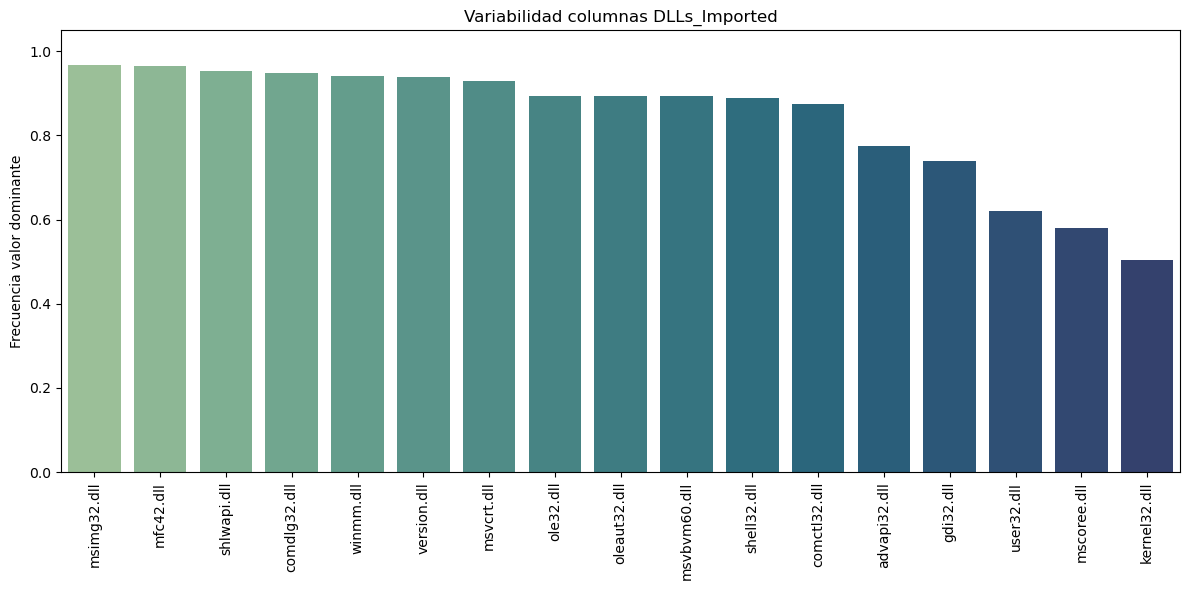

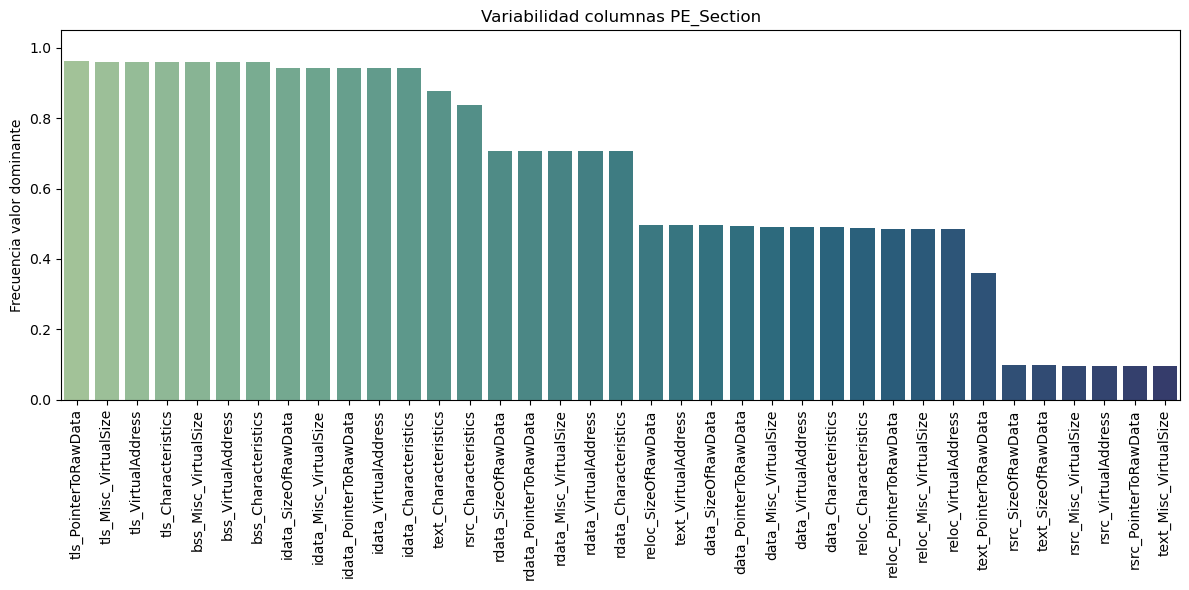

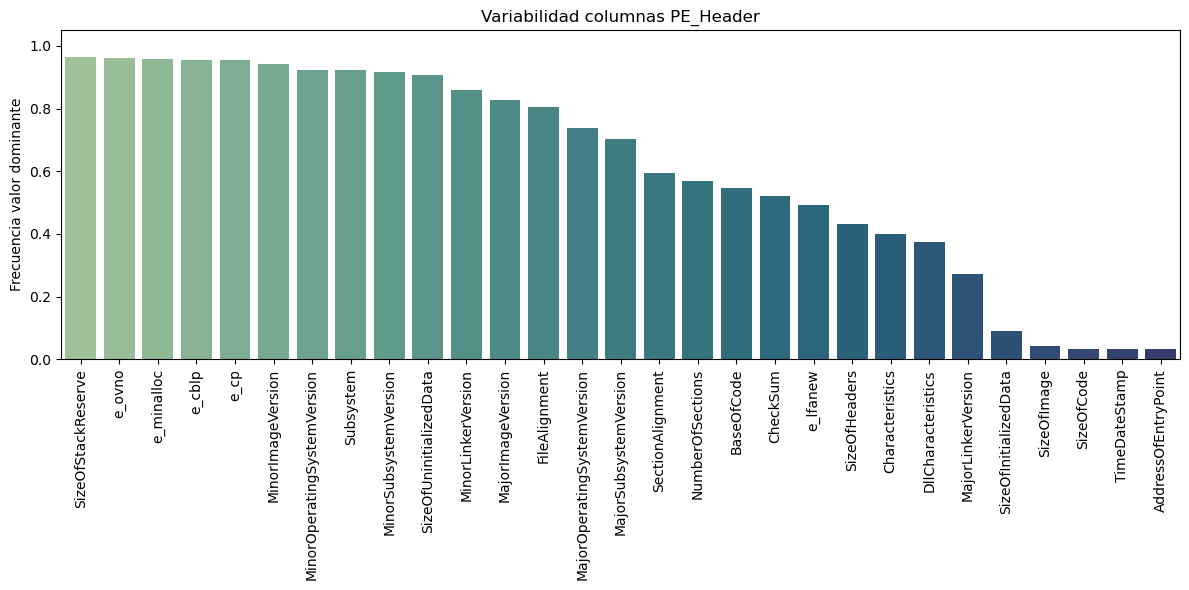

In [247]:
warnings.filterwarnings("ignore", category=FutureWarning)
plot_column_variability(dllimported, title='Variabilidad columnas DLLs_Imported')
plot_column_variability(pesection, title='Variabilidad columnas PE_Section')
plot_column_variability(peheader, title='Variabilidad columnas PE_Header')

In [248]:
merged_df = dllimported.merge(peheader, on='SHA256', how='inner', suffixes=('', '_header')) # para indicar que esas columnas pertenecen al dataset de header
merged_df = merged_df.merge(pesection, on='SHA256', how='inner', suffixes=('', '_section')) # para indicar que las columnas pertenecen al dataset de section

El conjunto de datos final tiene 29495 filas y 87 columnas.



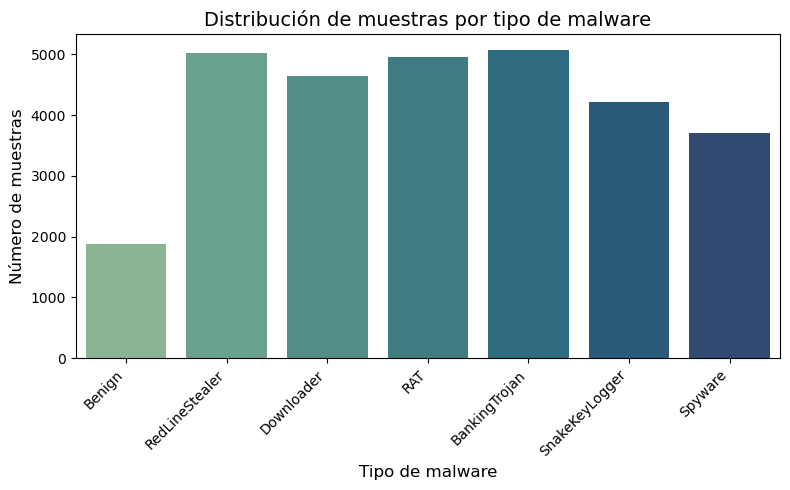

In [249]:
print(f"El conjunto de datos final tiene {merged_df.shape[0]} filas y {merged_df.shape[1]} columnas.\n")

class_map = {
    0: 'Benign',
    1: 'RedLineStealer',
    2: 'Downloader',
    3: 'RAT',
    4: 'BankingTrojan',
    5: 'SnakeKeyLogger',
    6: 'Spyware'
}

class_counts = merged_df['Type'].value_counts().sort_index()

plot_df = pd.DataFrame({
    'ClassName': [class_map[i] for i in class_counts.index],
    'Count': class_counts.values
})

plt.figure(figsize=(8,5))
sns.barplot(x=plot_df['ClassName'], y=plot_df['Count'], palette='crest')

plt.title('Distribución de muestras por tipo de malware', fontsize=14)
plt.xlabel('Tipo de malware', fontsize=12)
plt.ylabel('Número de muestras', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [197]:
merged_df.head()

,SHA256,Type,advapi32.dll,kernel32.dll,ole32.dll,oleaut32.dll,shlwapi.dll,user32.dll,msvcrt.dll,shell32.dll,...,rsrc_Characteristics,reloc_Misc_VirtualSize,reloc_VirtualAddress,reloc_SizeOfRawData,reloc_PointerToRawData,reloc_Characteristics,tls_Misc_VirtualSize,tls_VirtualAddress,tls_PointerToRawData,tls_Characteristics
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,0,1,1,1,1,1,0,0,0,...,1073741888,4836,405504,5120,379904,1107296320,0,0,0,0
1,2a053f32b1d48539e3e2807f86754be87ce95b08378467...,0,1,1,0,0,0,0,0,0,...,1073741888,6068,241664,6144,80384,1107296320,0,0,0,0
2,2f031a1752f7067fb9f483ae0ac5f3036c9b66cc4af40e...,0,1,1,1,0,0,1,1,1,...,1073741888,204,53248,512,34816,1107296320,0,0,0,0
3,308e8bb2e8a3b67607d2454370e0b50147b42049bda813...,0,1,1,1,1,1,1,0,0,...,1073741888,562,90112,1024,72192,1107296320,0,0,0,0
4,31aaba443b9869e6e68c17125f8d7989cbd762fb38ae3a...,0,1,1,0,0,0,0,0,0,...,1073741888,8230,114688,8704,100352,1107296320,9,106496,98304,3221225536


In [205]:
merged_df.to_csv('merged_df.csv', index=False)

# Primer testeo

Objetivo	
- Generalizar a nuevos datos reales (producción)	
- Reducir overfitting y hacer el modelo más robusto	
- Reducir tamaño del dataset y el tiempo de entrenamiento	
- Explicar mejor los resultados (interpretabilidad)	
- Detectar errores o inconsistencias en los datos	

¿Por qué preprocesar?
- Porque los datos futuros pueden no tener duplicados, y quieres que el modelo no dependa de patrones “repetidos” artificialmente.
- Aunque hoy funcione bien, un cambio en los datos podría hacer que el rendimiento caiga si no está bien preprocesado.
- Si eliminas ruido y duplicados, el modelo puede entrenar más rápido sin perder capacidad predictiva.
- Modelos sobre datos limpios, reducidos y transformados son más fáciles de entender y justificar ante otros.
- A veces, lo que parece que "funciona" puede estar sesgado o contener etiquetas incorrectas, y la limpieza ayuda a encontrar esos casos.

La comparación es la clave en la mejora: ver el impacto positivo (o no) que tiene los cambios realizados a la hora de escalar el modelo a datos no etiquetados o evaluados por el modelo previamente.

In [275]:
X_unprocessed = merged_unprocessed_df.drop(columns=['SHA256', 'Type'])
y_unprocessed = merged_unprocessed_df['Type']

X_train_unprocessed, X_test_unprocessed, y_train_unprocessed, y_test_unprocessed = train_test_split(X_unprocessed, y_unprocessed, test_size=0.2, random_state=42, stratify=y)

# Random Forest
model_unprocessed = RandomForestClassifier(
    n_estimators=100,        
    random_state=42,
    n_jobs=-1,               # Para más rapidez
    class_weight="balanced"  # Para el desbalanceo de clases
)

model_unprocessed.fit(X_train, y_train)

y_pred = model_unprocessed.predict(X_test)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Accuracy: 0.9989828784539753

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00      1004
           2       1.00      1.00      1.00       929
           3       1.00      1.00      1.00       991
           4       1.00      1.00      1.00      1015
           5       1.00      1.00      1.00       845
           6       1.00      1.00      1.00       740

    accuracy                           1.00      5899
   macro avg       1.00      1.00      1.00      5899
weighted avg       1.00      1.00      1.00      5899


 Confusion Matrix:
 [[ 374    1    0    0    0    0    0]
 [   0 1002    0    2    0    0    0]
 [   0    0  929    0    0    0    0]
 [   0    0    0  990    1    0    0]
 [   0    0    0    1 1014    0    0]
 [   0    0    0    0    0  845    0]
 [   0    0    0    0    0    1  739]]


In [269]:
X = merged_df.drop(columns=['SHA256', 'Type'])
y = merged_df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(
    n_estimators=100,        
    random_state=42,
    n_jobs=-1,               
    class_weight="balanced"  
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Accuracy: 0.9989828784539753

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00      1004
           2       1.00      1.00      1.00       929
           3       1.00      1.00      1.00       991
           4       1.00      1.00      1.00      1015
           5       1.00      1.00      1.00       845
           6       1.00      1.00      1.00       740

    accuracy                           1.00      5899
   macro avg       1.00      1.00      1.00      5899
weighted avg       1.00      1.00      1.00      5899


 Confusion Matrix:
 [[ 374    1    0    0    0    0    0]
 [   0 1002    0    2    0    0    0]
 [   0    0  929    0    0    0    0]
 [   0    0    0  990    1    0    0]
 [   0    0    0    1 1014    0    0]
 [   0    0    0    0    0  845    0]
 [   0    0    0    0    0    1  739]]


In [271]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre=''):
    print(f"\n--- Evaluación del modelo: {nombre} ---")

    # Medir tiempo de entrenamiento
    start_train = time.time()
    modelo.fit(X_train, y_train)
    train_time = time.time() - start_train

    # Medir tiempo de predicción
    start_pred = time.time()
    y_pred = modelo.predict(X_test)
    pred_time = time.time() - start_pred

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Tiempo de entrenamiento: {train_time:.2f}s")
    print(f"Tiempo de predicción: {pred_time:.2f}s")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return {
        'accuracy': acc,
        'train_time': train_time,
        'predict_time': pred_time
    }

In [277]:
result_baseline = evaluar_modelo(model_unprocessed, X_train_unprocessed, y_train_unprocessed, X_test_unprocessed, y_test_unprocessed, "Sin preprocesamiento")
result_preproc  = evaluar_modelo(rf_model, X_train, y_train, X_test, y_test, "Con preprocesamiento")

# Comparativa rápida
print("\n--- Comparación ---")
for key in result_baseline:
    diff = result_preproc[key] - result_baseline[key]
    print(f"{key}: sin = {result_baseline[key]:.4f}, con = {result_preproc[key]:.4f}, diferencia = {diff:+.4f}")



--- Evaluación del modelo: Sin preprocesamiento ---
Accuracy: 0.9986
Tiempo de entrenamiento: 2.19s
Tiempo de predicción: 0.14s

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00      1004
           2       1.00      1.00      1.00       929
           3       0.99      1.00      1.00       991
           4       1.00      1.00      1.00      1015
           5       1.00      1.00      1.00       845
           6       1.00      1.00      1.00       740

    accuracy                           1.00      5899
   macro avg       1.00      1.00      1.00      5899
weighted avg       1.00      1.00      1.00      5899


Confusion matrix:
[[ 374    1    0    0    0    0    0]
 [   0 1000    0    4    0    0    0]
 [   0    0  929    0    0    0    0]
 [   0    0    0  990    1    0    0]
 [   0    0    0    1 1014    0    0]
 [   0    0    0    0    0  845    0]
 [ 